<a href="https://colab.research.google.com/github/takumaosada/COVID-19-Basic-Analysis/blob/master/signate_covid19_case_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの読み込み

In [48]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install japanize_matplotlib
!pip install category_encoders
!pip install xgboost
!pip install optuna
import japanize_matplotlib
import category_encoders as ce
import gspread
import re
import itertools
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, roc_curve
from sklearn.linear_model import LogisticRegression
from oauth2client.client import GoogleCredentials
from google.colab import auth
import warnings
import xgboost as xgb
from IPython.display import clear_output
import optuna
auth.authenticate_user()

     |████████████████████████████████| 235kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 11.0MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 81kB 8.1MB/s 
     |████████████████████████████████| 51kB 2.9MB/s 
     |████████████████████████████████| 112kB 20.5MB/s 
     |████████████████████████████████| 122kB 16.8MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=631208806c3b347213221f05f9dd6d3efba72dab61ea40e196dc74a540372941
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-2.0.0-cp36-none-any.whl size=312964 sha256=f14d16762a5280bf7bd93c54666bde763923e325c4811607c9eb056b1d04cd2c
  Stored in directory: /root/.cache/pip/wheels/b5

In [2]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [3]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1VLSA8q2zPCbaTDXXcMsxK0HRZlFRVH7_x0rLd4Z7Jk8/edit#gid=960903158'
book = gc.open_by_url(singatecasefilelink)
casedata = book.worksheet('罹患者').get_all_values()
casedf = pd.DataFrame(casedata)

In [4]:
#データフレームを整理していく
area_dict = dict(zip(casedf.index, casedf.iloc[0]))
renamed_df = casedf.rename(columns=area_dict)
df = renamed_df.drop(0)
df =df.drop_duplicates()
df.drop(df.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
16156,50,1,50-1,,,,中部国際空港,,,,,,,,,,,,,,,,,,0,0,,,
16157,51,27,51-27,,2020/03/27,,関西国際空港,不明,,20 - 29,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16158,51,28,51-28,,2020/03/27,,関西国際空港,兵庫県,,非公表,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10539.html,,0,0,,,
16159,51,52,51-52,,2020/03/30,,関西国際空港,不明,,30 - 39,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29ドイツから帰国,0,0,,,
16160,51,53,51-53,,2020/03/30,,関西国際空港,不明,,40 - 49,男性,,無症状,0,,,,,,,,,https://www.mhlw.go.jp/stf/newpage_10638.html,3/29オランダから帰国,0,0,,,


# データの確認

In [5]:
df.describe()

,都道府県コード,症例番号,都道府県症例番号,発症日,確定日,公表日,受診都道府県,居住都道府県,居住市区町村,年代,性別,職業,ステータス,退院済ﾌﾗｸﾞ,基礎疾患ﾌﾗｸﾞ,症状・経過,症状一覧,行動歴,濃厚接触者状況,濃厚接触場所,海外渡航歴ﾌﾗｸﾞ,ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ,情報源,備考,罹患者関係_記入済ﾌﾗｸﾞ,罹患者トランザクション_記入済ﾌﾗｸﾞ,Relation1,Relation2,Transaction
count,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161,16161
unique,51,5175,16158,218,176,178,51,73,791,12,6,121,8,6,6,5995,1812,2907,3984,226,9,4,3232,1336,2,2,1796,3145,229
top,13,1,44-40,非公表,,2020/04/11,東京都,東京都,,50 - 59,男性,,,,,,,,,,,,,,0,0,,,
freq,5162,47,2,5205,4784,674,5162,3836,4638,2636,8682,6541,9412,8836,11928,8179,10814,9974,8403,12728,10125,10885,4091,12960,11874,15934,12364,12365,13890


In [6]:
# nullの値があるかどうか確認
df.isnull().sum()

都道府県コード                  0
症例番号                     0
都道府県症例番号                 0
発症日                      0
確定日                      0
公表日                      0
受診都道府県                   0
居住都道府県                   0
居住市区町村                   0
年代                       0
性別                       0
職業                       0
ステータス                    0
退院済ﾌﾗｸﾞ                  0
基礎疾患ﾌﾗｸﾞ                 0
症状・経過                    0
症状一覧                     0
行動歴                      0
濃厚接触者状況                  0
濃厚接触場所                   0
海外渡航歴ﾌﾗｸﾞ                0
ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ    0
情報源                      0
備考                       0
罹患者関係_記入済ﾌﾗｸﾞ            0
罹患者トランザクション_記入済ﾌﾗｸﾞ      0
Relation1                0
Relation2                0
Transaction              0
dtype: int64

In [7]:
# naの値があるかどうか確認
df.isna().sum()

都道府県コード                  0
症例番号                     0
都道府県症例番号                 0
発症日                      0
確定日                      0
公表日                      0
受診都道府県                   0
居住都道府県                   0
居住市区町村                   0
年代                       0
性別                       0
職業                       0
ステータス                    0
退院済ﾌﾗｸﾞ                  0
基礎疾患ﾌﾗｸﾞ                 0
症状・経過                    0
症状一覧                     0
行動歴                      0
濃厚接触者状況                  0
濃厚接触場所                   0
海外渡航歴ﾌﾗｸﾞ                0
ﾀﾞｲﾔﾓﾝﾄﾞﾌﾟﾘﾝｾｽ号乗船ﾌﾗｸﾞ    0
情報源                      0
備考                       0
罹患者関係_記入済ﾌﾗｸﾞ            0
罹患者トランザクション_記入済ﾌﾗｸﾞ      0
Relation1                0
Relation2                0
Transaction              0
dtype: int64

# データクリーニング


In [8]:
#性別でのデータクリーニングを行う
df = df[(df['性別'] == "男性") | (df['性別'] == '女性')]
#年代でのデータクリーニングを行う
df = df[(df['年代'] != "51 - 59") & (df['年代'] != '非公表') & (df['年代'] != '')]

In [9]:
#性別をencodeする
import category_encoders as ce
df_gender = df['性別']
list_cols = ['性別']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['性別'] = ce_ohe.fit_transform(df_gender)

In [10]:
#年代をencodeする
df_age = df['年代']
list_cols = ['年代']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
df['年代'] = ce_ohe.fit_transform(df_age)

# 症状のデータの読み込み

In [11]:
singatecasefilelink='https://docs.google.com/spreadsheets/d/1tnxt17rtmFnG4UNX8DXVXGUhCcL7-cXHE3hhoOpvfsk/edit#gid=577718303'
symptom_book = gc.open_by_url(singatecasefilelink)
symptom_data = symptom_book.worksheet('症状').get_all_values()
symptomdf = pd.DataFrame(symptom_data)

In [12]:
area_dict = dict(zip(symptomdf.index, symptomdf.iloc[0]))
renamed_df = symptomdf.rename(columns=area_dict)
symptomdf = renamed_df.drop(0)
symptomdf =symptomdf.drop_duplicates()
symptomdf.drop(symptomdf.index[-1]).tail()

,都道府県コード,症例番号,都道府県症例番号,症状・経過,日付,症状,確認済ﾌﾗｸﾞ
76108,,,,,(土),icd=J029;咽頭痛,
76109,,,,,(土),icd=R431;嗅覚障害,
76110,,,,,金),icd=J029;咽頭痛,
76111,,,,,金),icd=R431;嗅覚障害,
76114,39,82,39-82,2020/08/02 無症状。県内第81例目の濃厚接触者としてPCR検査実施。\n2020/...,-,-,-


In [13]:
symptomdf = symptomdf[(symptomdf['症状'] != "-")]

In [14]:
symptoms = symptomdf["症状"].unique()
symptoms_list = list()
for element in symptoms:
  elements = re.split('[;，]', element)
  symptoms_list.append(elements)

In [15]:
unique_symptons_list = list(itertools.chain.from_iterable(symptoms_list))
unique_symptons_list = list(set(unique_symptons_list))

In [16]:
#不要な要素を取り除く
# 検査しないとわからない項目は取り除く
# 今回は死亡、受診、入院、退院、肺炎を取り除く
# 追加で呼吸困難は影響が大きすぎるので排除する
cleaned_symptoms_list = list()
for element in unique_symptons_list:
  if not ("icd" in element or "受診" in element or "死亡" in element):
    if not ("入院" in element or "肺炎" in element or "退院" in element or "呼吸困難" in element):
        cleaned_symptoms_list.append(element)

In [17]:
cleaned_symptoms_list

['',
 '乏尿',
 '胸部不快感',
 '心不全',
 '咽頭炎',
 '肋骨痛',
 '聴覚障害',
 '腰痛症',
 '下腹痛',
 '発疹',
 '鼻汁',
 'コロナウイルス感染症',
 '下痢症',
 '耳痛症',
 '歩行困難',
 '結膜炎',
 '疼痛',
 '倦怠感',
 'ピリピリ感',
 '悪寒',
 '歯痛',
 '特発性拡張型心筋症',
 '味覚障害',
 '吐血',
 '呼吸促迫',
 '腰殿部痛',
 '悪寒戦慄',
 '微熱',
 '頻尿症',
 '糖尿病',
 '老衰',
 '高熱',
 '咽頭痛',
 '扁桃炎',
 '発汗障害',
 '咽喉頭異常感症',
 '項部痛',
 '胃腸炎',
 '感冒',
 '肩部痛',
 '肩こり',
 '花粉症',
 '関節痛',
 '多尿',
 '嗅覚異常',
 '胸痛',
 '神経痛',
 '嗅覚障害',
 'アレルギー',
 '胃痛',
 '膿性痰',
 '肝機能障害',
 '意識消失',
 '息切れ',
 '腎不全',
 '胸やけ',
 '急性耳痛',
 '腹部不快感',
 '結膜充血',
 '筋力低下',
 '不安障害',
 '発熱',
 '全身痛',
 '疲労感',
 '筋肉痛',
 '関節炎',
 '背部痛',
 '尿路感染症',
 '喀痰',
 '肺野異常陰影',
 '振戦',
 '腹痛症',
 '口渇症',
 '末梢循環障害',
 '味覚減退症',
 '高血圧症',
 '脂質異常症',
 '全身倦怠感',
 '喉頭炎',
 'ぶどう球菌感染症',
 '腰腹痛',
 '不明熱',
 '頚部痛',
 '麻疹',
 '呼吸不全',
 '項部腫脹',
 '動悸',
 '外傷',
 '紅斑症',
 '起立性眩暈',
 '味覚異常',
 '眼痛',
 '胸水貯留',
 '脱力感',
 '心肺停止',
 '拡張相肥大型心筋症',
 '頭痛',
 '乾性咳',
 '異常喀痰',
 '聴覚異常',
 '咳',
 'かぜ',
 '咽頭異常感症',
 '喉頭痛',
 '心配',
 '貧血',
 '嘔吐症',
 '胃腸疾患',
 'よう',
 '頚部腫脹',
 '急性上気道炎',
 '前胸部痛',
 'ほてり',
 '過剰喀痰',
 'インフルエンザ',
 'ブラ',
 '窒息感',
 '上腹部痛

# Xgboostを用いた分析

## データの整理

In [18]:
df_new = df[["都道府県コード", "年代", "性別", "ステータス", "症状一覧"]]

In [19]:
# ステータスは`非公開`や``をdropし、死亡を４、重症を3、中等症を２、軽症、無症状を1とする
df_new = df_new[(df['ステータス'] == "重症") | (df['ステータス'] == '軽症') | (df['ステータス'] == '死亡') | (df['ステータス'] == '無症状') | (df['ステータス'] == '中等症')]
df_new["ステータス"] = df_new["ステータス"].str.replace("重症", "1").str.replace("死亡", "1").str.replace("中等症", "0").str.replace("軽症", "0").str.replace("無症状", "0")
df_new["ステータス"] = df_new["ステータス"].astype(int)

In [20]:
for element in cleaned_symptoms_list:
  df_new[element] = df_new["症状一覧"].str.contains(element)

In [21]:
df_new["都道府県コード"] = df_new["都道府県コード"].astype(int)

In [22]:
df_new.dtypes

都道府県コード     int64
年代          int64
性別          int64
ステータス       int64
症状一覧       object
            ...  
血腫           bool
咳喘息          bool
胸部異常陰影       bool
鼻閉感          bool
めまい          bool
Length: 170, dtype: object

In [23]:
# 症状一覧をdropする
df_new = df_new.drop('症状一覧', axis=1)

## データの分析

In [24]:
params1 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'mae',
}

params2 = {
    'n_estimators': 5000,
    'max_depth': 7,
    'objective':'reg:linear',
    'min_child_weight': 4,
    'eta': 0.07,
    'eval_metric': 'auc',
}

In [25]:
def plot_xgboost_result(df):
  # モデルの作成(xgboost)
  x_train, x_test, y_train, y_test = train_test_split(df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1), df['ステータス'], stratify=df['ステータス'], test_size=0.3, random_state=0)

  dtrain = xgb.DMatrix(x_train, label=y_train)
  dtest = xgb.DMatrix(x_test, label=y_test)

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  model1= xgb.train(
      params1,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  y_pred = model1.predict(dtest)
  y_true = y_test.values

  train_metric = evals_result['train']['mae']
  eval_metric = evals_result['test']['mae']
  fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(24,15))
  axes[0,0].plot(train_metric, label='train mae')
  axes[0,0].plot(eval_metric, label='test mae', linestyle='dashed')
  axes[0,0].grid()
  axes[0,0].legend()
  axes[0,0].set_xlabel('学習回数')
  axes[0,0].set_ylabel('平均絶対誤差')

  xgb.plot_importance(model1, ax=axes[0,1], importance_type='gain', title='項目の重要度', show_values=False)
  axes[0,1].set_ylabel("項目")

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  # モデルの作成(AUC)
  model2 = xgb.train(
      params2,
      dtrain,
      num_boost_round=5000,
      evals=evals,
      early_stopping_rounds=30,
      evals_result=evals_result,
          )
  clear_output()

  check = model2.predict(dtest)
  fpr, tpr, thresholds = roc_curve(y_true, check)
  axes[1,0].plot(fpr, tpr, marker='o')
  axes[1,0].set_xlabel('FPR: False positive rate')
  axes[1,0].set_ylabel('TPR: True positive rate')
  axes[1,0].grid()

  history = xgb.cv(params1, dtrain, num_boost_round=200, early_stopping_rounds=10, nfold=10, verbose_eval=False, stratified=True)
  train_metric = history['train-mae-mean']
  eval_metric = history['test-mae-mean']
  axes[1,1].plot(train_metric, label='train mae')
  axes[1,1].plot(eval_metric, label='eval mae', linestyle='dashed')
  axes[1,1].grid()
  axes[1,1].legend()
  axes[1,1].set_xlabel('round')
  axes[1,1].set_ylabel('mae')
  print("重症,死亡の患者の数", df['ステータス'].value_counts()[1], '-', df['ステータス'].value_counts()[0])
  print("AUCのベストスコア", model2.best_score)

In [26]:
def cross_validation(df):
  x = df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1)
  y = df['ステータス']
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)
  model = LogisticRegression().fit(x_train, y_train)
  kf_with_shuffle = KFold(n_splits = 10, shuffle = True, random_state = 0)
  kf_without_shuffle = KFold(n_splits = 10, shuffle = False, random_state = 0)
  strat_kf_with_shuffle = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
  strat_kf_withøut_shuffle = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
  test_data_score = model.score(x_test, y_test)
  kfold_scores_with_shuffle = cross_val_score(model, x, y, cv=kf_with_shuffle)
  kfold_scores_without_shuffle = cross_val_score(model, x, y, cv=kf_without_shuffle)
  strat_kfold_score_with_shuffle = cross_val_score(model, x, y, cv=strat_kf_with_shuffle)
  strat_kfold_score_without_shuffle = cross_val_score(model, x, y, cv=strat_kf_withøut_shuffle)
  print("テストデータのスコア", test_data_score)
  print("交差検証のスコア平均(シャッフルあり)", kfold_scores_with_shuffle.mean())
  print("交差検証のスコア平均(シャッフルなし)", kfold_scores_without_shuffle.mean())
  print("層化k分割交差検証のスコア平均(シャッフルあり)", strat_kfold_score_with_shuffle.mean())
  print("層化k分割交差検証のスコア平均(シャッフルなし)", strat_kfold_score_without_shuffle.mean())

In [27]:
def simple_boosting(df, random_state):
  x_train, x_test, y_train, y_test = train_test_split(df.drop('都道府県コード', axis=1).drop(['ステータス'], axis=1), df['ステータス'], stratify=df['ステータス'], test_size=0.3, random_state=random_state)

  dtrain = xgb.DMatrix(x_train, label=y_train)
  dtest = xgb.DMatrix(x_test, label=y_test)

  evals = [(dtrain, 'train'), (dtest, 'test')]

  evals_result = {}

  model1= xgb.train(
    params1,
    dtrain,
    num_boost_round=5000,
    evals=evals,
    early_stopping_rounds=30,
    evals_result=evals_result,
    verbose_eval=0
  )
  y_pred = model1.predict(dtest)
  print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)), "random_state", random_state)

## 全体

[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:07:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

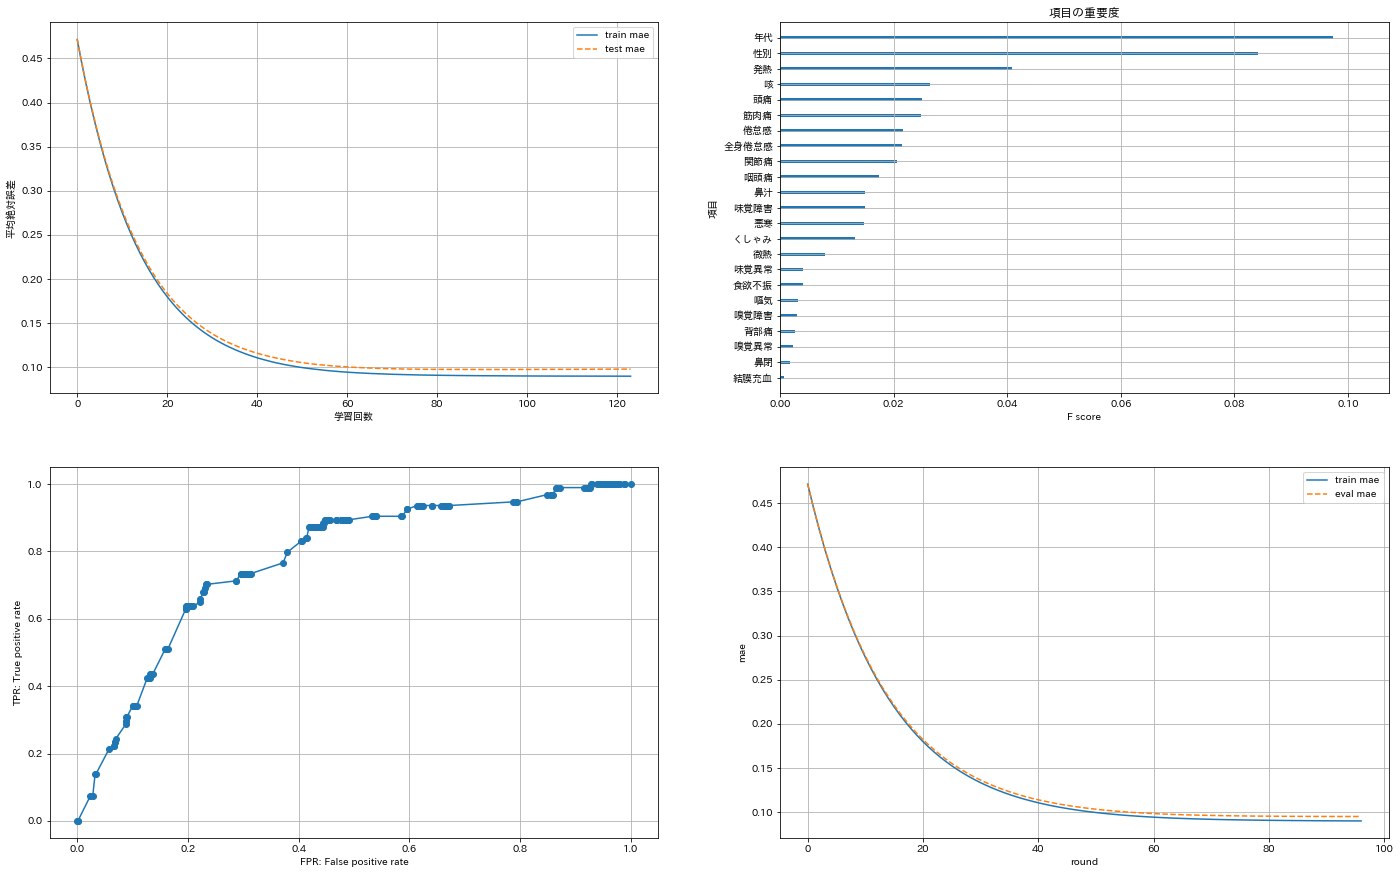

In [28]:
# 都道府県の項目は外す
plot_xgboost_result(df_new)

In [29]:
warnings.filterwarnings('ignore')
cross_validation(df_new)

テストデータのスコア 0.9457900807381776
交差検証のスコア平均(シャッフルあり) 0.9459949746031555
交差検証のスコア平均(シャッフルなし) 0.945985979262742
層化k分割交差検証のスコア平均(シャッフルあり) 0.9459928756903924
層化k分割交差検証のスコア平均(シャッフルなし) 0.9459928756903924


In [30]:
for random_state in range(0, 1000, 100): # 一番良かったスコアはrandom_state = 700
  simple_boosting(df_new, random_state)

[18:08:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE 0.2243492293056923 random_state 0
[18:08:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE 0.2210438844640053 random_state 100
[18:08:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE 0.2190588994498652 random_state 200
[18:08:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE 0.2210815217700843 random_state 300
[18:08:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE 0.21979570742411317 random_state 400
[18:08:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE 0.218196032472397 random_stat

## 東京のみ(重傷者4人/全体222人)

In [31]:
# df_new_tokyo = df_new[df_new["都道府県コード"] == 13]
# plot_xgboost_result(df_new_tokyo)

In [32]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_tokyo)

## 神奈川のみ(重傷者56人/全体806人)

[18:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

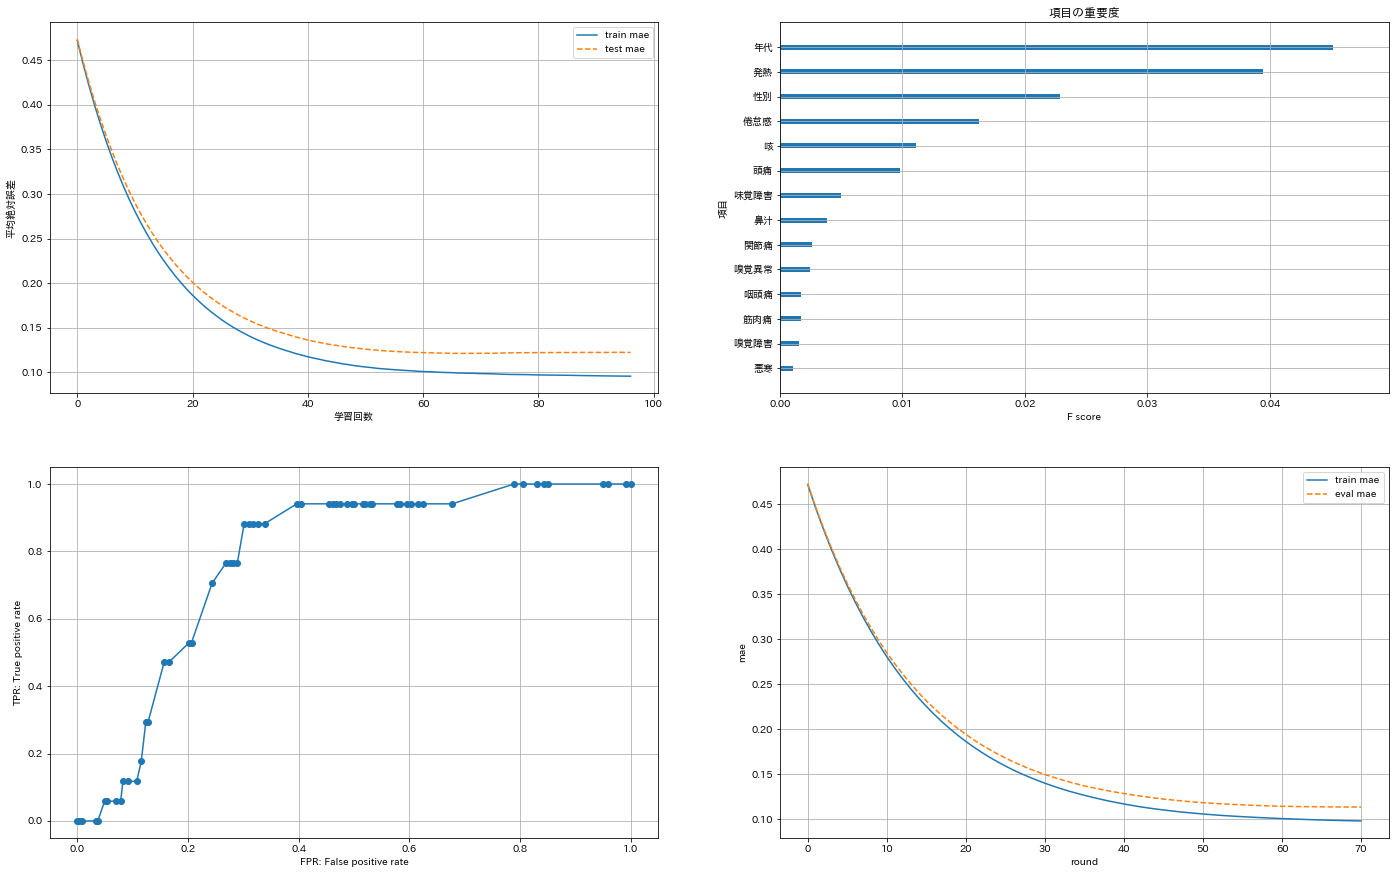

In [33]:
df_new_kanagawa = df_new[df_new["都道府県コード"] == 14]
plot_xgboost_result(df_new_kanagawa)

In [34]:
warnings.filterwarnings('ignore')
cross_validation(df_new_kanagawa)

テストデータのスコア 0.9343629343629344
交差検証のスコア平均(シャッフルあり) 0.935084202085004
交差検証のスコア平均(シャッフルなし) 0.9351242983159583
層化k分割交差検証のスコア平均(シャッフルあり) 0.9350441058540497
層化k分割交差検証のスコア平均(シャッフルなし) 0.9350441058540497


## 北海道のみ(重傷者34人/全体924人)

[18:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

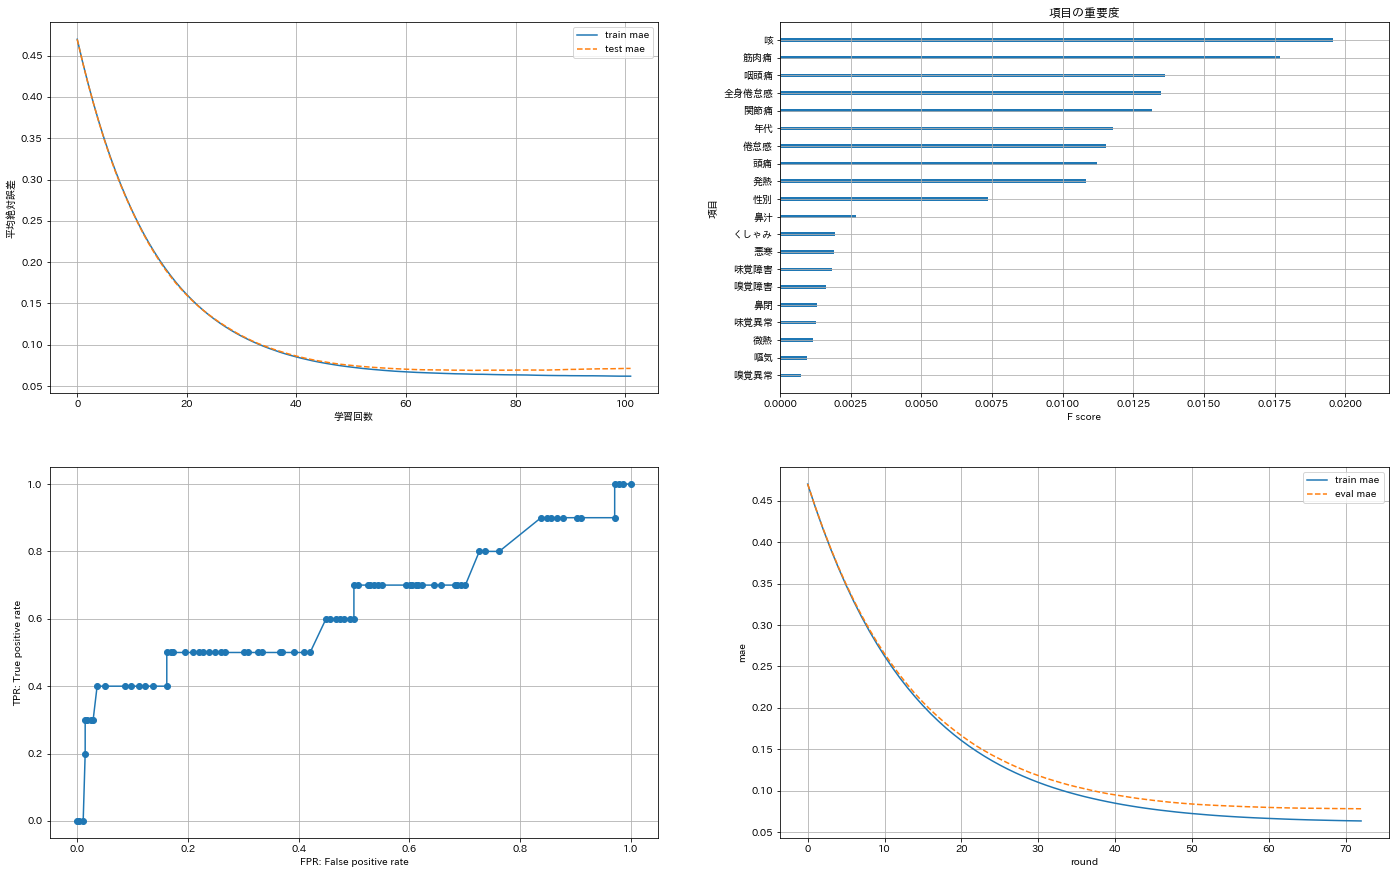

In [35]:
df_new_hokkaido = df_new[df_new["都道府県コード"] == 1]
plot_xgboost_result(df_new_hokkaido)

In [36]:
warnings.filterwarnings('ignore')
cross_validation(df_new_hokkaido)

テストデータのスコア 0.9652777777777778
交差検証のスコア平均(シャッフルあり) 0.9644956140350878
交差検証のスコア平均(シャッフルなし) 0.9645175438596493
層化k分割交差検証のスコア平均(シャッフルあり) 0.964517543859649
層化k分割交差検証のスコア平均(シャッフルなし) 0.964517543859649


## 近畿地方(重傷者169人/全体1878人)

[18:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

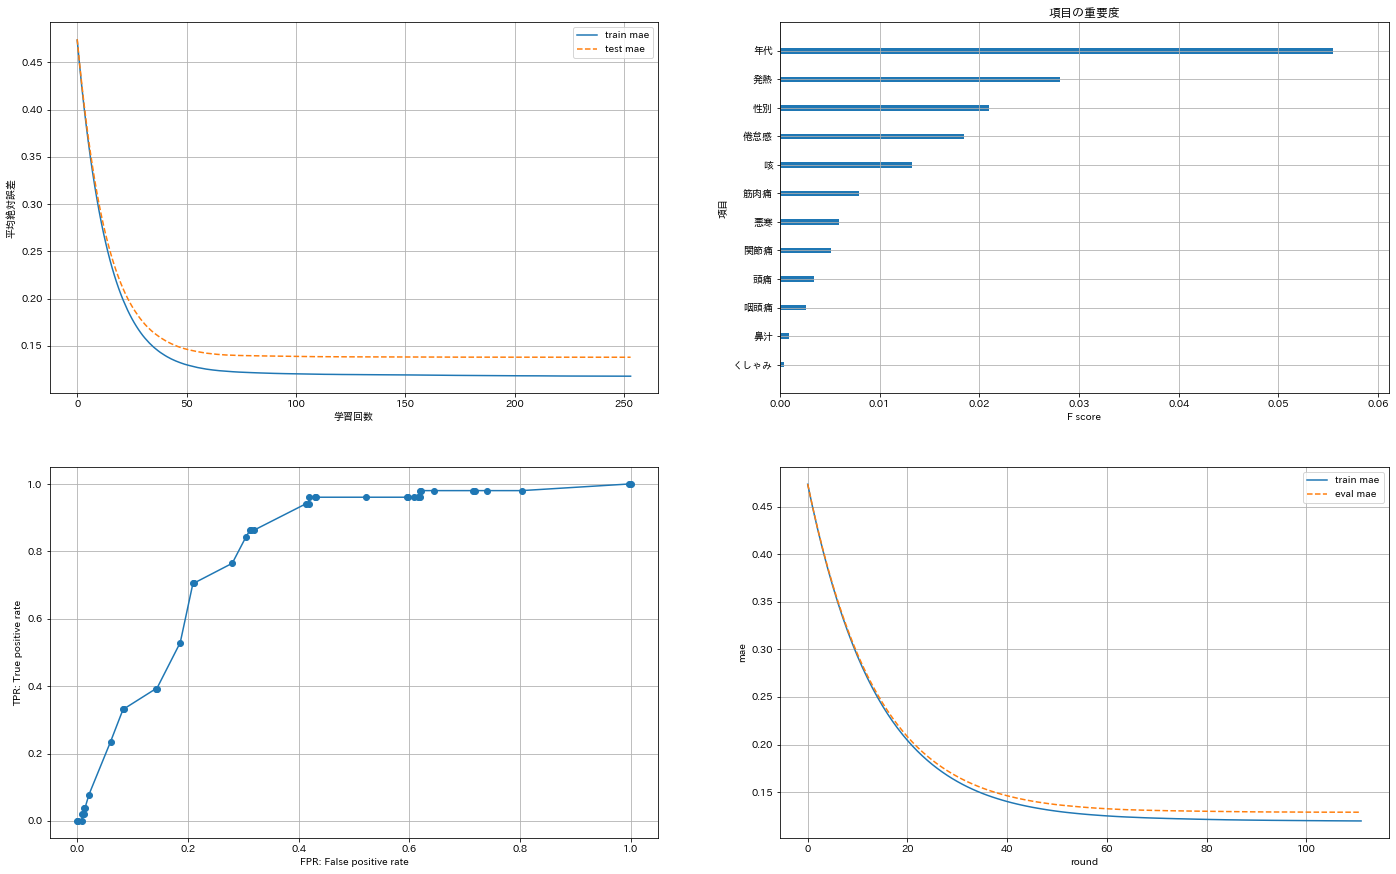

In [37]:
df_new_kinki = df_new[(df_new["都道府県コード"] == 24) | (df_new["都道府県コード"] == 25) | (df_new["都道府県コード"] == 26) | (df_new["都道府県コード"] == 27) | (df_new["都道府県コード"] == 28) | (df_new["都道府県コード"] == 29) | (df_new["都道府県コード"] == 30)]
plot_xgboost_result(df_new_kinki)

In [38]:
warnings.filterwarnings('ignore')
cross_validation(df_new_kinki)

テストデータのスコア 0.9170731707317074
交差検証のスコア平均(シャッフルあり) 0.9174653275944523
交差検証のスコア平均(シャッフルなし) 0.9174605451936871
層化k分割交差検証のスコア平均(シャッフルあり) 0.9174414155906264
層化k分割交差検証のスコア平均(シャッフルなし) 0.9174414155906264


## 関東地方(重傷者72人/全体1552人)

[18:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:09:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

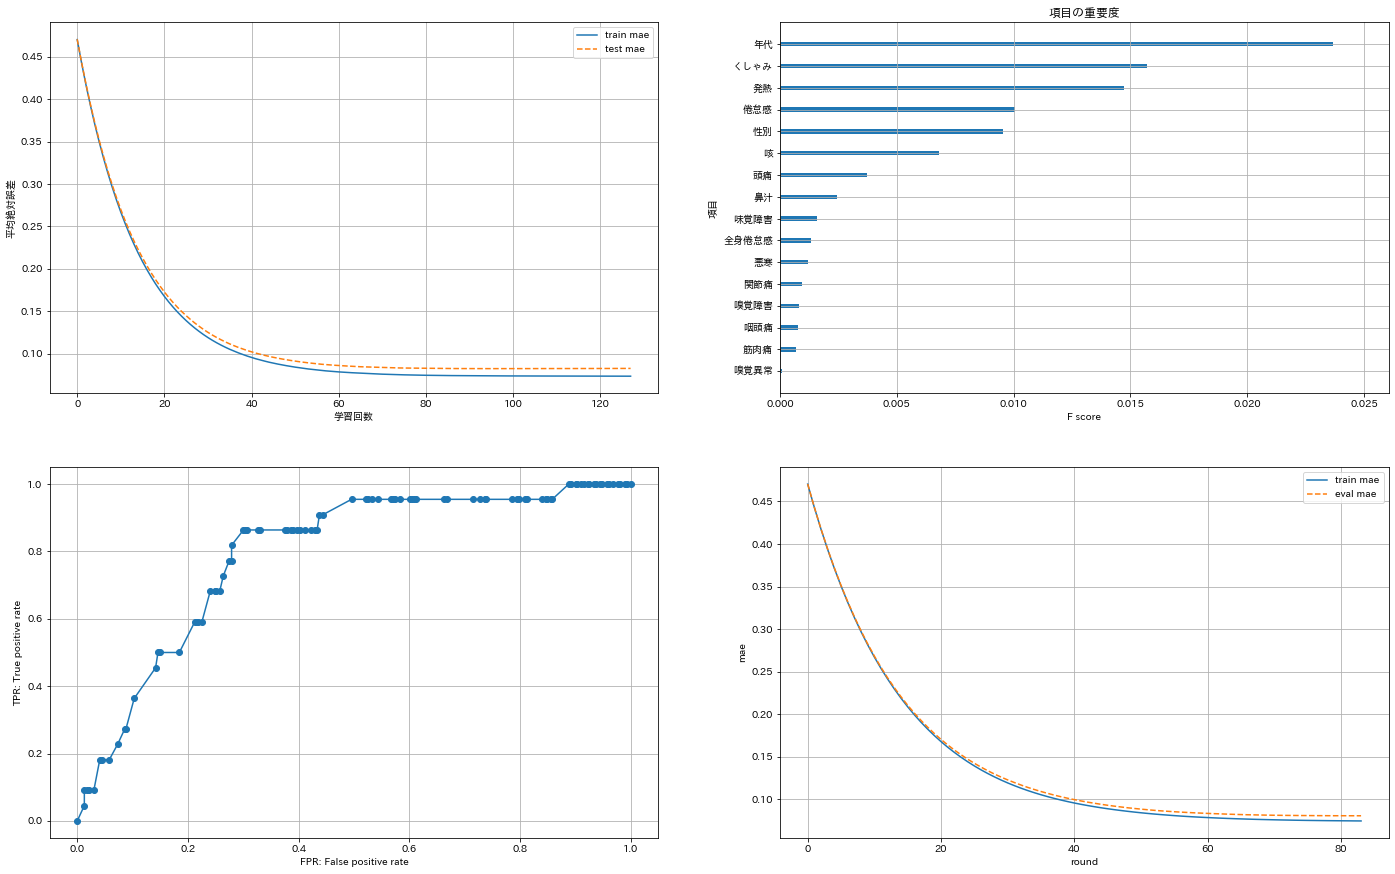

In [39]:
df_new_kanto = df_new[(df_new["都道府県コード"] == 8) | (df_new["都道府県コード"] == 9) | (df_new["都道府県コード"] == 10) | (df_new["都道府県コード"] == 11) | (df_new["都道府県コード"] == 12) | (df_new["都道府県コード"] == 13) | (df_new["都道府県コード"] == 14)]
plot_xgboost_result(df_new_kanto)

In [40]:
warnings.filterwarnings('ignore')
cross_validation(df_new_kanto)

テストデータのスコア 0.9549180327868853
交差検証のスコア平均(シャッフルあり) 0.9556691660986141
交差検証のスコア平均(シャッフルなし) 0.9556123608270847
層化k分割交差検証のスコア平均(シャッフルあり) 0.955669166098614
層化k分割交差検証のスコア平均(シャッフルなし) 0.955669166098614


## 中部地方(重傷者33人/全体651人)

In [41]:
# df_new_chubu = df_new[(df_new["都道府県コード"] == 15) | (df_new["都道府県コード"] == 16) | (df_new["都道府県コード"] == 17) | (df_new["都道府県コード"] == 18) | (df_new["都道府県コード"] == 19) | (df_new["都道府県コード"] == 20) | (df_new["都道府県コード"] == 21) | (df_new["都道府県コード"] == 22) | (df_new["都道府県コード"] == 23)]
# plot_xgboost_result(df_new_chubu)

In [42]:
# warnings.filterwarnings('ignore')
# cross_validation(df_new_chubu)

## 九州地方


In [43]:
# df_new_kyushu = df_new[(df_new["都道府県コード"] == 40) | (df_new["都道府県コード"] == 41) | (df_new["都道府県コード"] == 42) | (df_new["都道府県コード"] == 43) | (df_new["都道府県コード"] == 44) | (df_new["都道府県コード"] == 45) | (df_new["都道府県コード"] == 46) | (df_new["都道府県コード"] == 47)]
# plot_xgboost_result(df_new_kyushu)

## 四国地方

In [44]:
# df_new_shikoku = df_new[(df_new["都道府県コード"] == 36) | (df_new["都道府県コード"] == 37) | (df_new["都道府県コード"] == 38) | (df_new["都道府県コード"] == 39)]
# plot_xgboost_result(df_new_shikoku)

## 東北地方

In [45]:
# df_new_tohoku = df_new[(df_new["都道府県コード"] == 2) | (df_new["都道府県コード"] == 3) | (df_new["都道府県コード"] == 4) | (df_new["都道府県コード"] == 5) | (df_new["都道府県コード"] == 6) | (df_new["都道府県コード"] == 7)]
# plot_xgboost_result(df_new_tohoku)

## 中国地方

In [46]:
# df_new_chugoku = df_new[(df_new["都道府県コード"] == 31) | (df_new["都道府県コード"] == 32) | (df_new["都道府県コード"] == 33) | (df_new["都道府県コード"] == 34) | (df_new["都道府県コード"] == 35)]
# plot_xgboost_result(df_new_chugoku)